In [1]:
%load_ext autoreload
%autoreload 2
import time
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from estimation_fct import *

# Load model
from model import ModelClass

model = ModelClass() 

par = model.par
sol = model.sol
sim = model.sim


In [2]:
# Prepare data
mean, weights, moments = prepare_data(par)

In [3]:
rows_to_drop = np.arange(40+70+55, 40+70+55+15)
cols_to_drop = np.arange(40+70+55, 40+70+55+15)

mean_drop = np.delete(mean, rows_to_drop, axis=0)

weights_drop = np.delete(weights, rows_to_drop, axis=0)
weights_drop = np.delete(weights_drop, cols_to_drop, axis=1)


In [4]:
var1 = np.mean(mean[:40])
var2 = np.mean(mean[40:110])
var3 = np.mean(mean[110:165])
var4 = np.mean(mean[180:])

n = 205
test_weight = np.zeros((n, n))

# fill only the four blocks with 1/var^2
blocks = [
    (0,    40,  var1),
    (40,  110,  var2),
    (110, 165,  var3),
    (180, 205,  var4)
]

for start, end, v in blocks:
    idx = np.arange(start, end)
    test_weight[idx, idx] = 1.0 / (v**2)


In [5]:
def randomize_theta_init(theta_init, bounds, pct=0.10):
    randomized = []
    for val, (lower, upper) in zip(theta_init, bounds):
        delta = pct * val
        min_val = max(lower, val - delta)
        max_val = min(upper, val + delta)
        randomized_val = np.random.uniform(min_val, max_val)
        randomized.append(randomized_val)
    return np.array(randomized)

# Prepare SMM
theta_names = ("beta", "sigma", "gamma", "mu", "zeta", "beta_1")

theta_init = np.array([0.966053, 1.164098, 2.520728, 6.974234, 6.861415, 0.056831])

# Original bounds
orig_bounds = [(0.0, 1.0),   # beta
               (0.1, 6.0),   # sigma
               (0.1, 10.0),  # gamma
               (0.0, 20.0),  # mu
               (0.0, 15.0),  # zeta
               (0.0, 1.0)
               ] 

theta_init_scaled = scale_params(theta_init, orig_bounds)

theta_random = randomize_theta_init(theta_init, orig_bounds)
theta_random_scaled = scale_params(theta_random, orig_bounds)

In [ ]:
# Do SMM
objective = lambda theta: obj_func(theta, theta_names, mean_drop, weights_drop, model, orig_bounds, do_print=True)

res = minimize(
    objective, 
    theta_init_scaled,
    method='nelder-mead',
    bounds=[(0,1)] * len(theta_init_scaled),
    tol=1e-6,
    options={"maxiter":2000}
)


0.966053, 1.164098, 2.520728, 6.974234, 6.861415, 0.056831, 
Error = 2.48, Time = 110.9132 seconds
0.985644, 1.164098, 2.520728, 6.974234, 6.861415, 0.056831, 
Error = 12.71, Time = 44.3297 seconds
0.966053, 1.217303, 2.520728, 6.974234, 6.861415, 0.056831, 
Error = 25.66, Time = 44.2645 seconds
0.966053, 1.164098, 2.641764, 6.974234, 6.861415, 0.056831, 
Error = 2.66, Time = 46.1191 seconds
0.966053, 1.164098, 2.520728, 7.322946, 6.861415, 0.056831, 
Error = 2.55, Time = 43.8510 seconds
0.966053, 1.164098, 2.520728, 6.974234, 7.204486, 0.056831, 
Error = 2.45, Time = 44.2262 seconds
0.966053, 1.164098, 2.520728, 6.974234, 6.861415, 0.059673, 
Error = 2.62, Time = 43.6200 seconds
0.972583, 1.110893, 2.561073, 7.090471, 6.975772, 0.057778, 
Error = 53.56, Time = 43.7963 seconds
0.967686, 1.190700, 2.530814, 7.003293, 6.890004, 0.057068, 
Error = 7.39, Time = 44.2911 seconds
0.947006, 1.172965, 2.564436, 7.100158, 6.985302, 0.057857, 
Error = 5.39, Time = 43.8120 seconds
0.958071, 1.1404

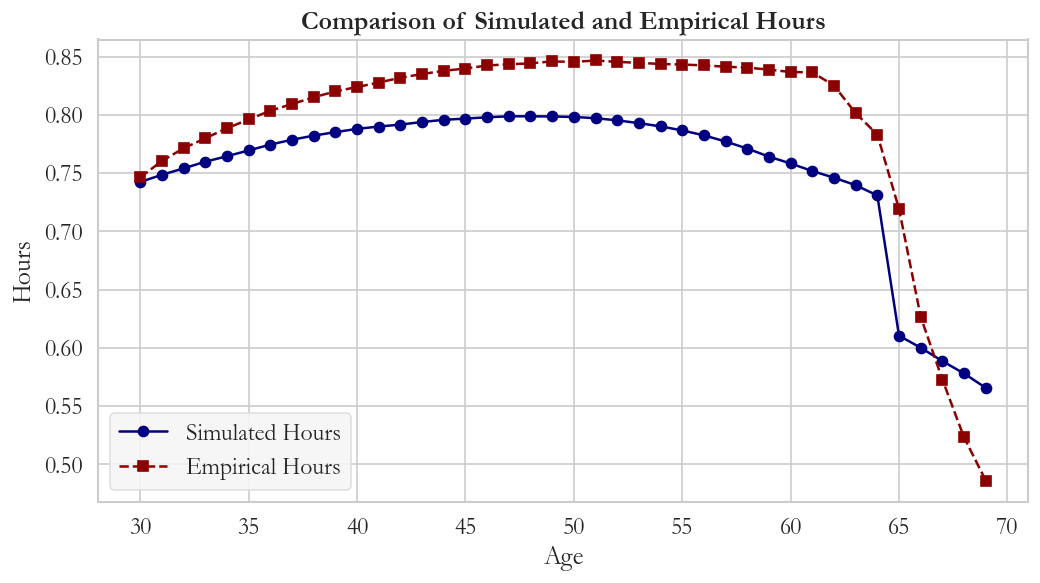

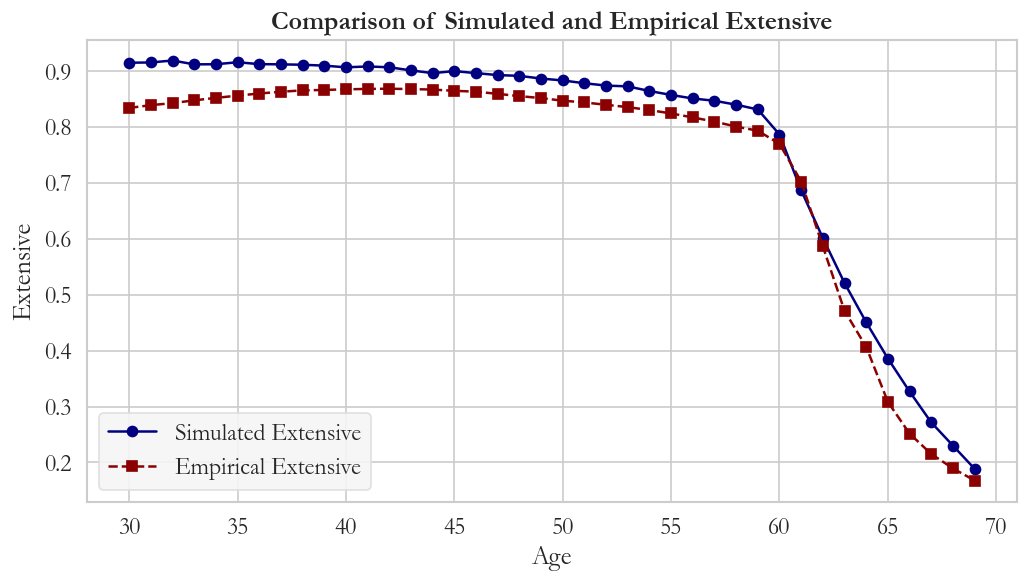

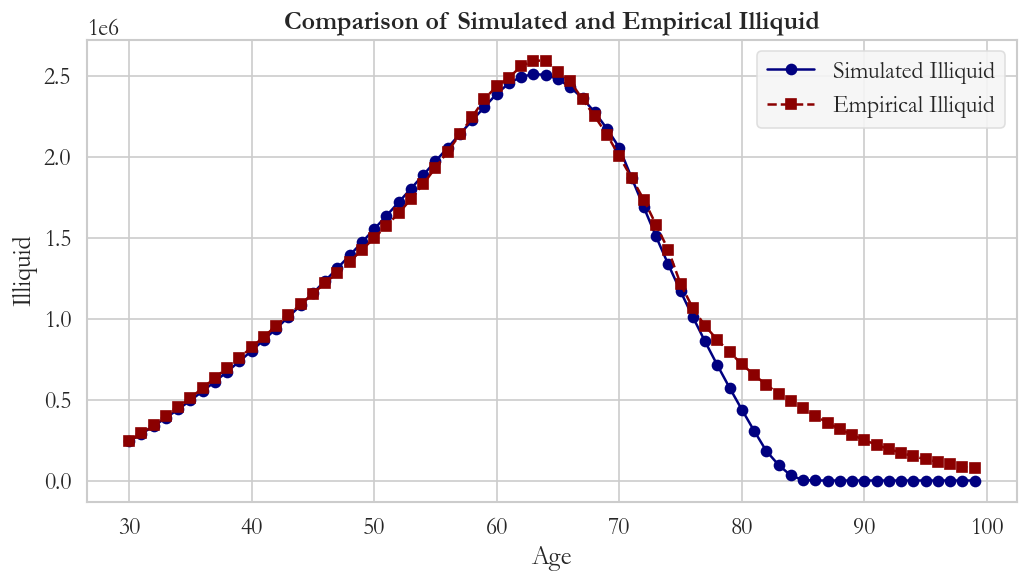

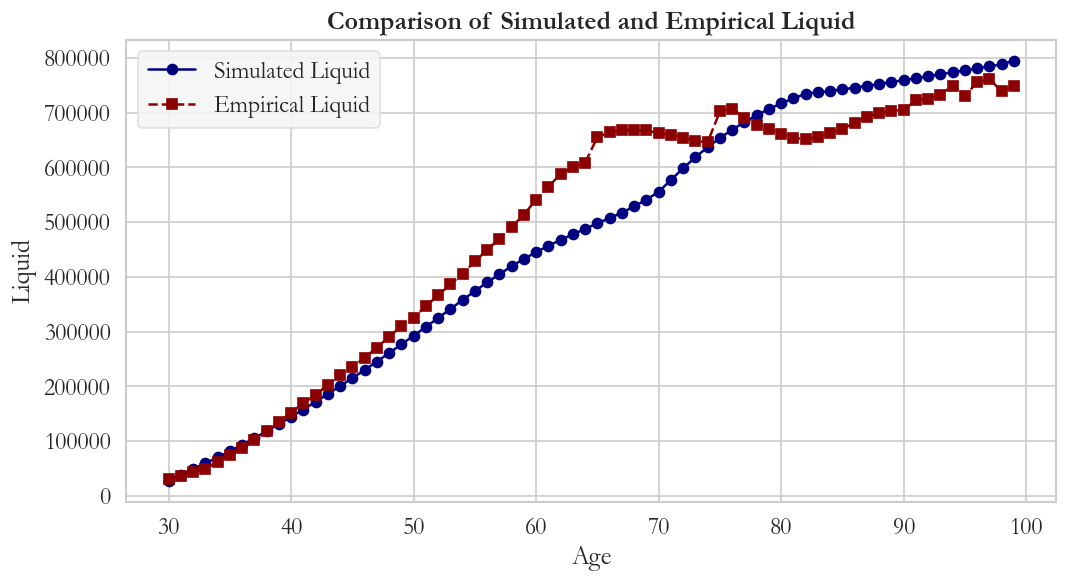

In [ ]:
# Load the model with calibrated values
theta_names = ("beta", "sigma", "gamma", "mu", "zeta", "beta_1")
theta_final = unscale_params(res.x, orig_bounds)
# theta_final = theta_init
# theta_final =  np.array([0.975674, 1.112808, 1.9774010, 8.535116, 9.155991])
# theta_final =  np.array([0.978606, 1.174380, 2.679981, 5.731359, 4.729426, 0.068225]) # For høj ekstensiv
# theta_final =  np.array([0.967581, 1.090430, 2.057090, 13.011158, 11.117360])
# theta_final = np.array([0.960325, 1.066230, 1.946620, 6.430758, 13.138969, 0.068225])
# theta_final =  np.array([0.959897, 1.065429, 1.933390, 6.710345, 13.421021, 0.0672287])
# theta_final = np.array([0.960683, 1.064129, 1.896356, 6.921994, 13.370719, 0.067684])  # Bedre ekstensiv, 2.50
# theta_final = np.array([0.961189, 1.063088, 1.934371, 6.931359, 13.220911, 0.068225]) # Optimizer siger den her er bedst, 2.40
# theta_final = np.array([0.968394, 1.163527, 2.637719, 6.770023, 4.699147, 0.066668])
# theta_final = np.array([0.970957, 1.160198, 2.734833, 5.979640, 4.977325, 0.063388]) # Faktisk ret god
# theta_final = np.array([0.970987, 1.159477, 2.649623, 5.985134, 4.995703, 0.064703])
# theta_final = np.array([0.973970, 1.172141, 2.742543, 5.786726, 6.998144, 0.061258])
# theta_final = np.array([0.967887, 1.166134, 2.510759, 6.692900, 6.837467, 0.059119])


for i, name in enumerate(theta_names):
    setattr(model.par, name, theta_final[i])

model.solve()
model.simulate()

# plot the graph with calibrated values 
a_dict = {
    'hours': [np.nanmean(np.where(model.sim.ex == 1, model.sim.h, np.nan),axis=0)[:40], moments['hours']],
    'extensive': [np.mean(model.sim.ex, axis=0)[:40], moments['extensive']],
    'illiquid': [np.clip(np.mean(model.sim.s, axis=0), 0, None), moments['savings']],
    'liquid': [np.mean(model.sim.a, axis=0), moments['assets']]
}

# Define colors
simulated_color = "navy"  # Dark blue
empirical_color = "darkred"  # Dark red
ci_color = "lightcoral"  # Light red for confidence bands

for key, (simulated, empirical) in a_dict.items():
    plt.figure(figsize=(10, 5))
    
    x_vals = np.arange(len(empirical)) + par.start_age
    
    plt.plot(x_vals, simulated, label=f"Simulated {key.capitalize()}", marker="o", color=simulated_color)
    plt.plot(x_vals, empirical, label=f"Empirical {key.capitalize()}", linestyle="--", marker="s", color=empirical_color)

    # # 99.9% confidence interval
    # ci = std_dev
    # plt.fill_between(x_vals, empirical - ci, empirical + ci, color=ci_color, alpha=0.4, label="Empirical Standard Deviation")

    plt.xlabel("Age")
    plt.ylabel(key.capitalize())
    plt.title(f"Comparison of Simulated and Empirical {key.capitalize()}")
    plt.legend()
    plt.grid(True)
    plt.show()


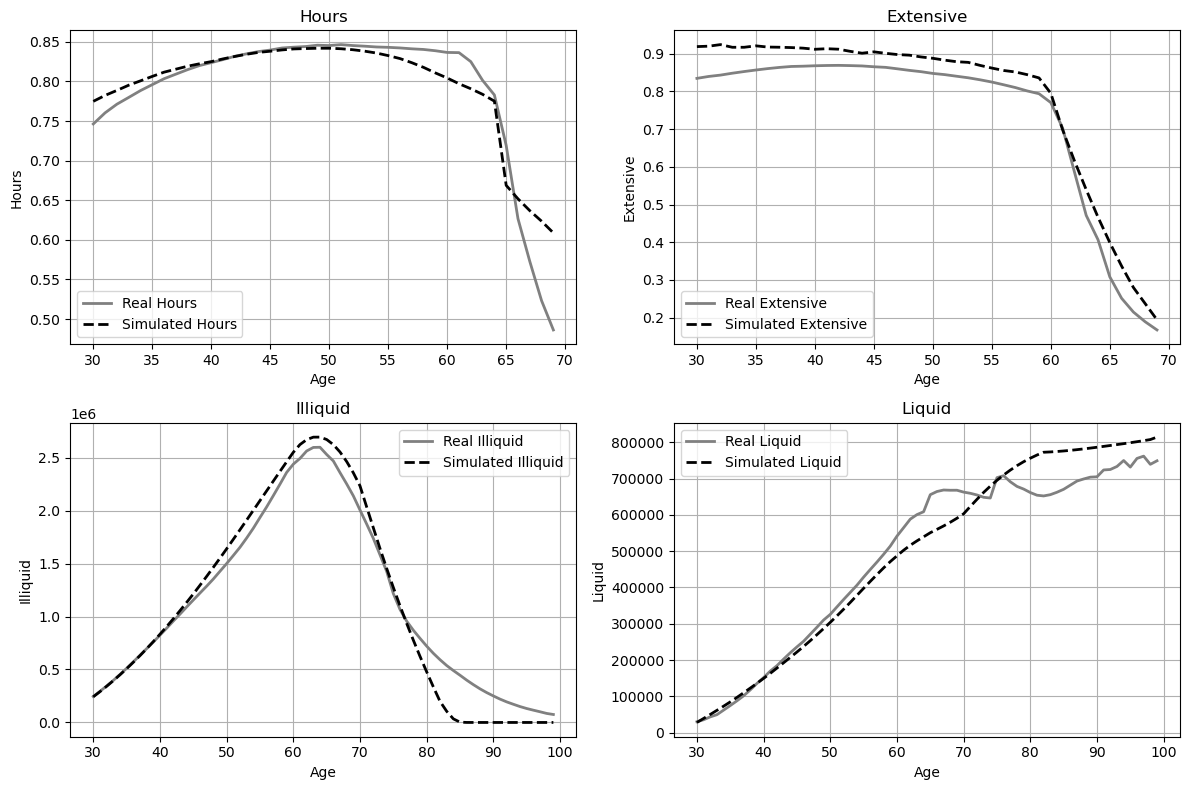

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# prepare your data dict
a_dict = {
    'hours': [np.nanmean(np.where(model.sim.ex == 1, model.sim.h, np.nan), axis=0)[:40],
              moments['hours']],
    'extensive': [np.mean(model.sim.ex, axis=0)[:40],
                  moments['extensive']],
    'illiquid': [np.clip(np.mean(model.sim.s, axis=0), 0, None),
                 moments['savings']],
    'liquid': [np.mean(model.sim.a, axis=0),
               moments['assets']]
}

# set up 2x2 axes
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, (key, (sim, emp)) in zip(axes, a_dict.items()):
    x_vals = np.arange(len(emp)) + par.start_age

    # real data: solid grey
    ax.plot(x_vals, emp,
            color='grey',
            linestyle='-',
            linewidth=2,
            label=f"Real {key.capitalize()}")

    # simulated data: darker dashed
    ax.plot(x_vals, sim,
            color='black',
            linestyle='--',
            linewidth=2,
            label=f"Simulated {key.capitalize()}")

    ax.set_xlabel("Age")
    ax.set_ylabel(key.capitalize())
    ax.set_title(key.capitalize())
    ax.grid(True)
    ax.legend()

fig.tight_layout()
plt.show()


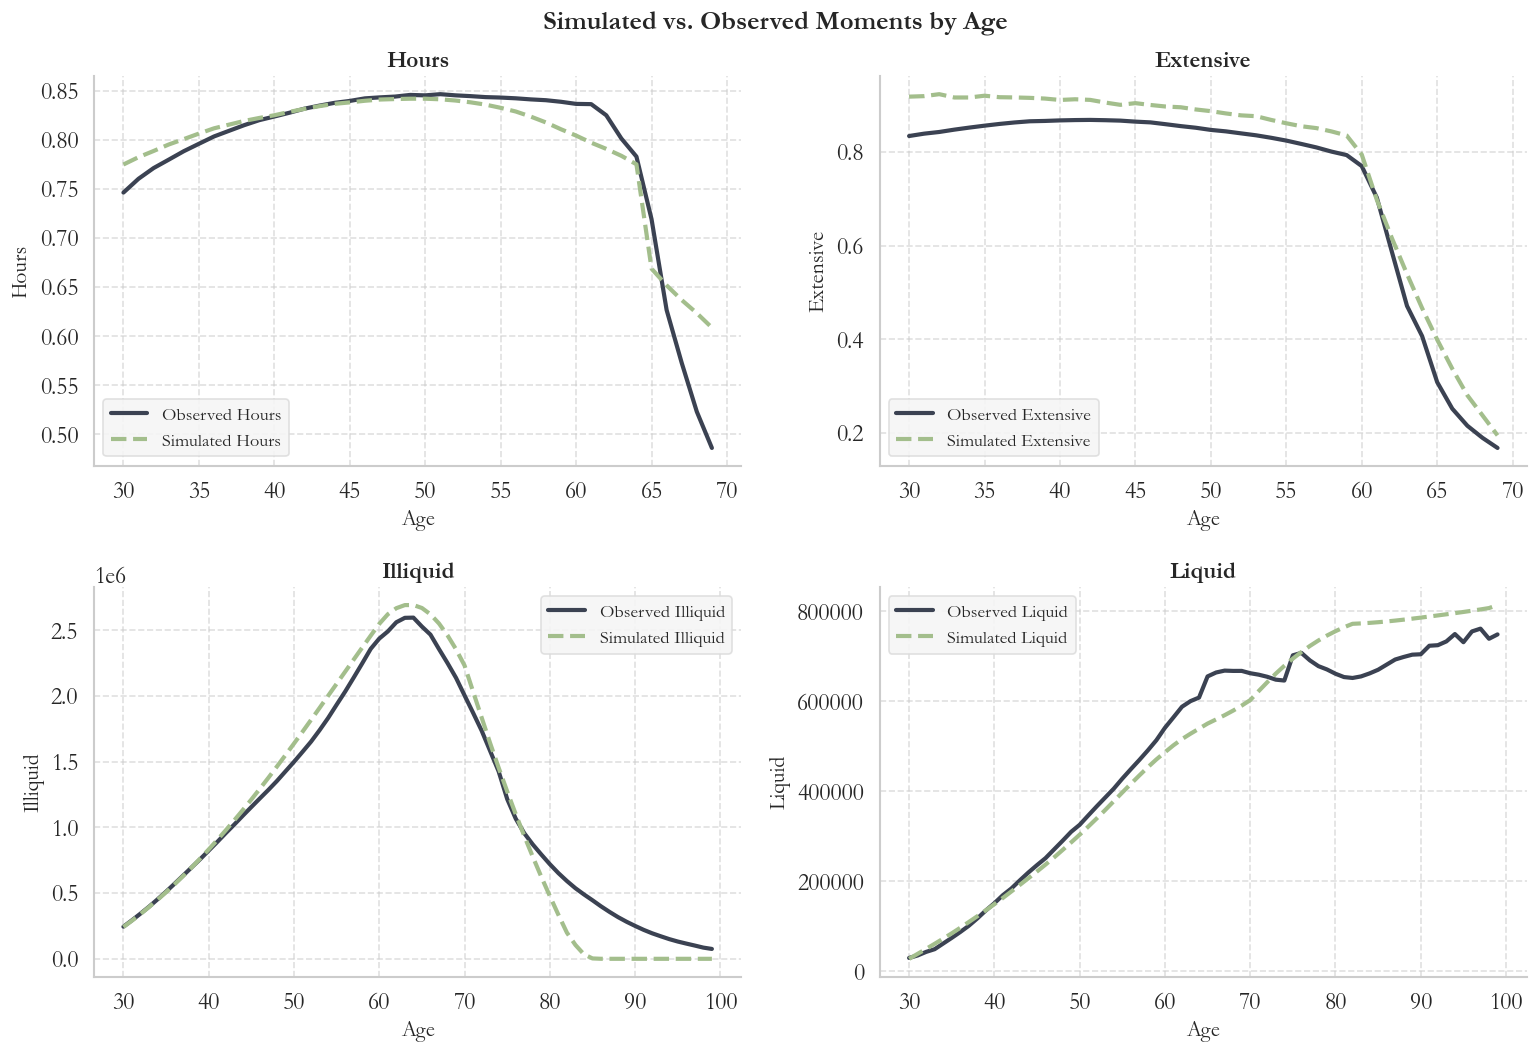

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from graph_format import custom_palette, save_figure

# Apply global styling
sns.set_theme(context="notebook", style="whitegrid", font="garamond", palette=custom_palette, font_scale=1.3)

# Prepare data dict
a_dict = {
    'Hours': [np.nanmean(np.where(model.sim.ex == 1, model.sim.h, np.nan), axis=0)[:40],
              moments['hours']],
    'Extensive': [np.mean(model.sim.ex, axis=0)[:40],
                  moments['extensive']],
    'Illiquid': [np.clip(np.mean(model.sim.s, axis=0), 0, None),
                 moments['savings']],
    'Liquid': [np.mean(model.sim.a, axis=0),
               moments['assets']]
}

# Plot setup
fig, axes = plt.subplots(2, 2, figsize=(13, 9))
axes = axes.flatten()

for idx, (ax, (key, (sim, emp))) in enumerate(zip(axes, a_dict.items())):
    x_vals = np.arange(len(emp)) + par.start_age

    # Real data: solid custom color
    ax.plot(x_vals, emp,
            color=custom_palette[0],
            linestyle='-',
            linewidth=2.5,
            label=f"Observed {key}")

    # Simulated data: dashed custom color
    ax.plot(x_vals, sim,
            color=custom_palette[1],
            linestyle='--',
            linewidth=2.5,
            label=f"Simulated {key}")

    ax.set_xlabel("Age", fontsize=13)
    ax.set_ylabel(key, fontsize=13)
    ax.set_title(key, fontsize=14, fontweight="semibold")
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(fontsize=11, frameon=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.suptitle("Simulated vs. Observed Moments by Age", fontsize=16, fontweight="bold")
fig.tight_layout()
fig.subplots_adjust(top=0.92)

# Save with consistent style
save_figure(fig, "sim_vs_real_moments_by_age.png")
plt.show()


Old best variables:

In [ ]:
theta_old = ([0.982, 1.060, 3.877, 7.814, 0.02, 0.009])